# Assignment 1

Lucas Sylvester - s214636 <br>
Lucas Emcken - s214625 <br>
Lila Meflah - s231660 <br>
**Github** \
https://github.com/LucasEmcken/SocialScienceAssignments

**Contribution statement** \
Everybody made all exercises before hand.\
The final assignment was made by combining and \
discussing different approaches to the each exercise.\
\
The git history is not representative as it was made using\
 VS code Live Share to work in unison on one computer in real time.





## Part 1 - Web-scraping


In [1]:
import bs4
import requests

from fuzzywuzzy import process

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
url = "https://ic2s2-2023.org/program"

response = requests.get(url)
soup = bs4.BeautifulSoup(response.content, 'html.parser')

#get content in section with id "main"
main = soup.find_all('section', id='main')

#get the list of each <\i> tag in the main section
authors_list = []

for section in main:
    #find italic tags since authors are in italic
    items = section.find_all('i')
    for item in items:
        authors = item.text
        for author in authors.split(","):
            author_strip = author.strip()
            #remove Chair: in the beginning of the name if it exists
            if author_strip.startswith("Chair:"):
                author_strip = author_strip[6:]
            authors_list.append(author_strip)

#remove duplicates
authors_list = list(set(authors_list))
print(f"initial length of authors list: {len(authors_list)}")

initial length of authors list: 1524


In [3]:
#use fuzzywuzzy to remove similar authors to further prevent misspelling and duplicates
def remove_similar_authors(authors, similarity_threshold = 85):
    unique_authors = []
    for author in authors:
        # Check if the author is too similar to any already in unique_authors
        if not unique_authors:
            unique_authors.append(author)
        else:
            similarities = [process.extractOne(author, [ua])[1] for ua in unique_authors]
            if all(sim < similarity_threshold for sim in similarities):
                unique_authors.append(author)
    return unique_authors

#sort authors list
authors_list.sort()

#split authors list into lists of n authors to speed up the process
n = 100
split_authors = [authors_list[i:i + n] for i in range(0, len(authors_list), n)]
cleaned_authors = []
for split in split_authors:
    cleaned_authors += remove_similar_authors(split)

print(f"length of cleaned authors: {len(cleaned_authors)}")
# Save the list to a file with UTF-8 encoding to handle special characters
with open("authors.txt", "w", encoding="utf-8") as f:
    for author in cleaned_authors:
        f.write(author + "\n")

length of cleaned authors: 1394


**1. How many researchers did you get?**\
Initially, we retrieved 1524 authors.
By sortin the list and cleaning using a Levenshtein distance similarity measure we got 1394 authors.
The threshhold for if names where the same where put at 85, all the cases we observed with this threshhold semeed to be correct. It might have missed a few really significand misspellings, but as in some of the examples below, it will have cleaned the majority of misspellings and variations.

**2. Explain the process you followed to web-scrape the page** \
For scraping, we noticed authors names were italicized so we retrieved this text. This also contained people with the Chair: tag in front, so we removed tag this by a simple comparison while retaining the name in the set. After this we used fuzzywuzzy to extract and compare similar author names. This removes duplicates as a result of misspellings or alternative names and such.

**Example of similar names removed:** \
Alessandro Flamini \
Alessandro Flammini \
similarity:97 \
\
Alexander Gates \
Alexander J Gates \
similarity:94 \
\
Ana Maria Jaramillo \
Ana María Jaramillo \
similarity:95\
\
Anne C Kroon\
Anne C. Kroon\
similarity: 96\
\
Anne C Kroon\
Anne Kroon\
similarity:91

## Part 2 - Ready Made vs Custom Made Data
**1. What are the pros and cons**
 - Custom made Data

*Pros:* Custom-made data means that the data was prepared on purpose. The data fit perfectly to
the research. Thus, they allow you to achieve exactly what you want. This kind of data offer
a great flexibility as you can modify and expand the research.

*Cons:* 
Participants may behave differently in controlled settings compared to natural environments, potentially leading to outcomes that are not exhibited in the real world. Additionally, custom made data can be resource intensive to gather.

 - Ready Made Data

*Pros:* Ready-made data should more accurately reflect real world behaviours and interactions. It is also more cost effective since the data is already made and available

*Cons:* The data may not fit the research purpose exactly, and there is limited control over the data collection methods and variables. Additionally, ready made data might not be available in the desired quantities.

**2. How can these differences influence interpretation (max 150. words)**\
In Nicolaides&#39;s study, interpreting the results can be more complex than in Centola&#39;s
experiment. Centola&#39;s experiment, being meticulously designed for the research, facilitates
clearer causal inferences between variables. Conversely, Nicolaides&#39;s study may encounter
the challenge of unknown variables affecting the outcomes, complicating the interpretation.

## Part 3 - Gathering Research Articles using the OpenAlex API

In [4]:
import pandas as pd
import tqdm
import concurrent.futures
import ast

In [5]:
#load author txt
def load_author_txt(file_path):
    with open(file_path, 'r', encoding="utf-8") as f:
        lines = f.readlines()
        authors = []
        for line in lines:
            line = line.strip()
            if len(line) > 0:
                authors.append(line)
    return authors

authors = load_author_txt('authors.txt')

In [6]:
endpoint = "https://api.openalex.org/authors?search="


def get_author_response(author):
    url = endpoint + author
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

#helper function to get the concepts from the author dictionary and the intercection if both required concept groups are present
def get_concepts(author_dict):
    concepts = [[c.get('display_name') for c in author_dict.get('results')[a].get('x_concepts')] for a in range(len(author_dict.get('results')))]
    return concepts

def get_best_match(concepts):
    target_1 = ['Sociology', 'Psychology', 'Economics', 'Political Science']
    target_2 = ['Mathematics', 'Physics', 'Computer Science']

    for i, author in enumerate(concepts):
        #get authors with concepts in target_1 AND target_2
        if (x in author for x in target_1) and (x in author for x in target_2):
            return i
    
    return 0

def get_info(auth_info):
    concepts = get_concepts(auth_info)
    c_index = get_best_match(concepts)
    
    #get their id
    author_id = auth_info.get('results')[c_index].get('id')[-11:]
    #get their display_name
    display_name = auth_info.get('results')[c_index].get('display_name')
    #get their works_api_url
    works_api_url = "https://api.openalex.org/works?filter=author.id:" + author_id
    #get their h_index
    h_index = auth_info.get('results')[c_index].get('summary_stats').get('h_index')
    #get their works count
    works_count = auth_info.get('results')[c_index].get('works_count')
    #get their cited_by_count
    cited_by_count = auth_info.get('results')[c_index].get('cited_by_count')
    
    #get their country code
    country_code = auth_info.get('results')[c_index].get('last_known_institution').get('country_code')

    return {
        'author_id': author_id,
        'display_name': display_name,
        'works_api_url': works_api_url,
        'h_index': h_index,
        'works_count': works_count,
        'cited_by_count': cited_by_count,
        'country_code': country_code
    }

def get_author_df(authors,*, n_workers = 3, load_if_exists = True, save_path = 'authors_df.csv'):
    
    if load_if_exists:
        try:
            authors_df = pd.read_csv(save_path)
            print(f'Loaded {len(authors_df)} authors from {save_path}')
            return authors_df
        except:
            print(f'Failed to load {save_path}, will create a new one..')
            
    authors_df = pd.DataFrame(columns=['author_id', 'display_name', 'works_api_url', 'h_index', 'works_count', 'cited_by_count', 'country_code'])
    err_authors = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_workers) as executor:
        future_to_author = {executor.submit(get_author_response, author): author for author in authors}
        futures = tqdm.tqdm(concurrent.futures.as_completed(future_to_author), total=len(authors))
        for future in futures:
            author = future_to_author[future]
            try:
                res = future.result()
                if res:
                    try:
                        info = get_info(res)
                        authors_df = pd.concat([authors_df, pd.DataFrame([info])])
                    except:
                        err_authors.append(author)
                else:
                    err_authors.append(author)
            except Exception as e:
                err_authors.append(author)
    print(f'Done!, Failed authors: {len(err_authors)}')
    #save to csv

    authors_df.to_csv(save_path, index=False)
    return authors_df

authors_df = get_author_df(authors)

Loaded 1237 authors from authors_df.csv


In [7]:
pruned_authors = authors_df[(authors_df['works_count'] > 5) & (authors_df['works_count'] < 5000) &
                              (authors_df['cited_by_count'] > 10)]

In [8]:
def get_intercept(concepts):
    target = ['Sociology', 'Psychology', 'Economics', 'Political Science']
    
    if any(x in concepts for x in target):
        return True
    else:
        return False
    
def get_works(url):
    
    # response = requests.get(url)
    filters = 'concepts_count:%3E1,authors_count:%3C10,concept.id:C33923547|C121332964|c41008148&per-page=200'
    filter_url = url + filters
    # return response.json()
    response = requests.get(filter_url, timeout=10).json()
    return_dict = {
        'id': [],
        'publication_year': [],
        'cited_by_count': [],
        'author_ids': [],
        'title': [],
        'abstract_inverted_index': []
    }
    
    page = 1
    # print(len(response.get('results')))
    while len(response.get('results')) != 0:
        for paper in response.get('results'):
            concepts = [c['display_name'] for c in paper['concepts']]
            if get_intercept(concepts):
                # return_dict['id'] = paper['id']
                return_dict['id'].append(paper['id'])
                return_dict['publication_year'].append(paper['publication_year'])
                return_dict['cited_by_count'].append(paper['cited_by_count'])
                
                #authorships
                return_dict['author_ids'].append([id.get('author').get('id') for id in paper['authorships']])
                
                
                return_dict['title'].append(paper['title'])
                # return_dict['abstract_inverted_index'] = ' '.join(list(paper['abstract_inverted_index'].keys())) if paper['abstract_inverted_index'] else []
                return_dict['abstract_inverted_index'].append(paper['abstract_inverted_index'])
        
        page += 1
        
        filters = f'concepts_count:%3E1,authors_count:%3C10,concept.id:C33923547|C121332964|c41008148&per-page=200&page={page}'
        filter_url = url + filters
        response = requests.get(filter_url).json()
                
    return return_dict
    

def combine_works(df, n_workers=3, load_if_exists=True, save_path='combined_works.csv'):
    if load_if_exists:
        try:
            combined_df = pd.read_csv(save_path)
            print('works found, formatting..')
            combined_df['author_ids'] = combined_df['author_ids'].apply(lambda x: ast.literal_eval(x))
            combined_df['abstract_inverted_index'] = combined_df['abstract_inverted_index'].apply(ast.literal_eval)
            print(f'Loaded {len(combined_df)} works from {save_path}')
            return combined_df
        except:
            print(f'Failed to load {save_path}, will create a new one..')
    
    combined_df = pd.DataFrame()
    
    failed = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(tqdm.tqdm(executor.map(get_works, df['works_api_url']), total=len(df)))
        for i in range(len(results)):
            try:
                works_df = pd.DataFrame(results[i])
                combined_df = pd.concat([combined_df, works_df])
            except:
                failed.append(i)
    
    print(f'Done!, Failed authors: {len(failed)}')
    #save to csv
    combined_df = combined_df.dropna()
    combined_df.to_csv(save_path, index=False)
    
    return combined_df

full_df = combine_works(pruned_authors, n_workers=5, load_if_exists=True)

works found, formatting..
Loaded 30287 works from combined_works.csv


In [9]:
full_df = full_df[full_df['cited_by_count'] > 10]
full_df = full_df[full_df['author_ids'].apply(lambda x: len(x) < 10)]

#split into IC2S2 papers and IC2S2 abstracts
ic2s2_papers = full_df[['id', 'publication_year', 'cited_by_count', 'author_ids']]
ic2s2_abstracts = full_df[['id', 'title', 'abstract_inverted_index']]

print(len(ic2s2_papers))

9394


In [10]:
#get the authors of the papers
def get_paper_authors(paper):
    author_ids = []
    for ids in paper['author_ids']:
        author_ids += ids
    author_ids = list(set(author_ids))
    
    api_authors = []
    for id in author_ids:
        api_authors.append(f'https://api.openalex.org/authors/{id[-11:]}')
    
    return api_authors

co_authors_apis = get_paper_authors(ic2s2_papers)

def get_author_info(url):
    
    try:
        response = requests.get(url, timeout=10).json()
        return_dict = {
            'id': "https://openalex.org/" + url[-11:],
            'display_name': response.get('display_name'),
            'works_api_url': response.get('works_api_url'),
            'h_index': response.get('summary_stats').get('h_index'),
            'works_count': response.get('works_count'),
            'country_code': response.get('last_known_institution').get('country_code')
        }
        return return_dict
    except:
        return_dict = {
            'display_name': None,
            'works_api_url': None,
            'h_index': None,
            'works_count': None,
            'country_code': None
        }
    
        return return_dict

def combine_authors(author_urls, n_workers=3, load_if_exists=True, save_path='co_authors.csv'):
    if load_if_exists:
        try:
            combined_df = pd.read_csv(save_path)
            print(f'Loaded {len(combined_df)} authors from {save_path}')
            return combined_df
        except:
            print(f'Failed to load {save_path}, will create a new one..')
    combined_df = pd.DataFrame()
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(tqdm.tqdm(executor.map(get_author_info, author_urls), total=len(author_urls)))
        for i in range(len(results)):
            author_df = pd.DataFrame(results[i], index=[0])
            combined_df = pd.concat([combined_df, author_df])
    #save to csv
    combined_df = combined_df.dropna()
    combined_df.to_csv(save_path, index=False)
    
    return combined_df

co_authors_df = combine_authors(co_authors_apis, load_if_exists=True)

Loaded 12488 authors from co_authors.csv


In [11]:
#create an authorship df with the display names from the co_authors_df compared with the author_ids from the ic2s2_papers
authorship_df = pd.DataFrame(columns=['paper_id', 'author_ids', 'display_names', 'countries', 'citation_count', 'publication_year'])

for i in tqdm.tqdm(range(len(ic2s2_papers))):
    paper = ic2s2_papers.iloc[i]
    author_ids = paper['author_ids']
    display_names = []
    countries = []
    for id in author_ids:
        author = co_authors_df[co_authors_df['id'] == id]
        if len(author) > 0:
            display_names.append(author['display_name'].values[0])
            countries.append(author['country_code'].values[0])
            
    authorship_df = pd.concat([authorship_df, pd.DataFrame({'paper_id': paper['id'],
                                                            'author_ids': [author_ids],
                                                            'display_names': [display_names],
                                                            'countries': [countries],
                                                            'citation_count': [paper['cited_by_count']],
                                                            'publication_year': [paper['publication_year']]})])

  0%|          | 11/9394 [00:00<01:29, 104.74it/s]

100%|██████████| 9394/9394 [00:58<00:00, 161.61it/s]


In [12]:
#sort by length of display names
authorship_df['len_display_names'] = authorship_df['display_names'].apply(lambda x: len(x))
authorship_df = authorship_df.sort_values(by='len_display_names', ascending=False)

#drop duplicates
co_authors_df.drop_duplicates(subset='id', inplace=True)
authorship_df.drop_duplicates(subset='paper_id', inplace=True)

In [13]:
#For every author in co authors, get all their citation counts and publication years from the authorship_df and add them to the co_authors_df
def get_author_citations(author, authorship_df):
    author_citations = authorship_df[authorship_df['display_names'].apply(lambda x: author in x)]
    author_citations = author_citations[['citation_count', 'publication_year']]
    return author_citations

def get_author_citations_df(authors, authorship_df):
    concat_frame = pd.DataFrame()

    for _,author in tqdm.tqdm(authors.iterrows(), total = len(authors)):
        
        citations = get_author_citations(author['display_name'], authorship_df)
        total_citations = citations['citation_count'].sum()
        
        first_year = citations['publication_year'].min()
        
        concat_frame = pd.concat([concat_frame, pd.DataFrame({'id': author['id'],
                                                              'total_citations': total_citations,
                                                              'first_year': first_year},
                                                             index=[0])])

    return concat_frame


author_citations = get_author_citations_df(co_authors_df, authorship_df)
#combine with co_authors_df
co_authors_df = co_authors_df.merge(author_citations, on='id')
#impute the country code as the most common country code
co_authors_df['country_code'] = co_authors_df['country_code'].fillna(co_authors_df['country_code'].mode()[0])

100%|██████████| 12488/12488 [00:56<00:00, 222.57it/s]


In [14]:
print(f"Number of researchers: {len(co_authors_df)}")
print(f"Number of Works: {len(authorship_df)}")

Number of researchers: 12488
Number of Works: 7719


**Dataset summary.** \
**How many works are listed in your IC2S2 papers dataframe?**\
After filtering we got 7719

**How many unique researchers have co-authored these works?**\
After filtering we got 12488

**Efficiency in code.**\
**Describe the strategies you implemented to make your code more efficient.** \

We implementet the following strategies:
1. Filtering directly in query to return fewer more relevant results, instead of purely filtering in code.
2. Added multithreading to make multiple calls while waiting for others

**How did your approach affect your code's execution time? (answer in max 150 words)**\
Multithreading sped up the API fetching significantly, however we did not implement fetching of multiple authors per call. Currently we are using a fixed amount of worker threads also, that often runs quite a bit lower than the 10 calls/second we have (usually 4-6 ). It might be possible to send workers to sleep and wake them up to run closer to the limit without reaching the limit

**Filtering Criteria and Dataset Relevance** \
**Reflect on the rationale behind setting specific thresholds for the total number of works by an author, the citation count, the number of authors per work, and the relevance of works to specific fields. How do these filtering criteria contribute to the relevance of the dataset you compiled? Do you believe any aspects of Computational Social Science research might be underrepresented or overrepresented as a result of these choices? (answer in max 150 words)**

The threshholding can be used to filter off mistakes. There instances of duplicates of authors, or authors who have several thousand works, aliases etc. Its for example reasonable that authors with more than 5000 works might have some mistakes in their record.
\
The limit of 10 authors per work, can be used to keep the author list relevant. If there are more than 10 authors for a work, the majority of them might have little part in work and could be less relevant. Relevant authors would likely show up on other works and be included through there. Likewise it is resonable to say that established research has at least 10 citations.

However, brand new reasearch that just been published might be underrepresented in citations. It might be that a new paper has not yet been reviewed and cited. Likewise, older and less relevant papers, might eventually get 10 citations over longer time

## Part 4 - The Network of Computational Social Scientists

In [15]:
#get the 10 largest countries by total_citations
top_10_countries = co_authors_df.groupby('country_code')['total_citations'].sum().nlargest(10).index
print(top_10_countries)

#generate color codes for the countries
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.values())
print(colors)

Index(['US', 'CN', 'GB', 'IT', 'NL', 'IL', 'DE', 'CA', 'FR', 'AU'], dtype='object', name='country_code')
['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [16]:
import networkx as nx
import netwulf as nw
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import json

In [17]:
#create a weighted edgelist weighted edgelist where each list element is a tuple containing three elements: the author ids of two collaborating authors and the total number of papers they've co-authored. Ensure each author pair is listed only once.

weighted_edgelist = []

def weighted_creation (df): 

    #list of all author    
    auth_pairs = []
    
    #get the list of authors in the dataframe 

    for _, row in df.iterrows():
        authors = row['author_ids']
    
        for pair in combinations(authors, 2): 
            
            auth_pairs.append(tuple(sorted(pair))) 

    #Count the occurrences of each author pair to determine the number of co-authored papers
    
    edge_weights = Counter(auth_pairs)

    # Convert the edge weights to a list of tuples in the format (author_id_1, author_id_2, weight)
    weighted_edgelist = [(pair[0], pair[1], weight) for pair, weight in edge_weights.items()]

    return weighted_edgelist

# weighted_creation(authorship_df)

def graph_construction (weighted_edgelist):
    # Create a new graph
    G = nx.Graph()
    
    # Add edges to the graph
    G.add_weighted_edges_from(weighted_edgelist)
    return G

def remove_nodes_without_attributes(G):
    nodes_without_size = [node for node, attrs in G.nodes(data=True) if 'size' not in attrs]
    for node in nodes_without_size:
        G.remove_node(node)
    
    nodes_without_color = [node for node, attrs in G.nodes(data=True) if 'color' not in attrs]
    for node in nodes_without_color:
        G.remove_node(node)

def node_attributes(G, df, file_path): 
    
    node_size_s = 10000
    
    max_citations = max(df['total_citations'])
    
    country_codes = {row['country_code'] for _, row in df.iterrows()}
    # country_colors = {code: colors[i] for i, code in enumerate(country_codes)}
    country_colors = {}
    for i, code in enumerate(country_codes):
        if code in top_10_countries:
            color_index = list(top_10_countries).index(code)
            country_colors[code] = colors[color_index]
        else:
            country_colors[code] = colors[-1]
    
    for _, row in df.iterrows():
        # Check if the author is a node in the graph
        if G.has_node(row['id']):
            # Set the author's attributes
            node_size_trans = np.sqrt(row['total_citations'])
            #add the minimum value to the log to prevent negative values
            node_size = node_size_trans / np.sqrt(max_citations) * node_size_s
            # node_size = row['total_citations'] / max_citations * node_size_s
            country_code = row['country_code']
            country_color = country_colors[country_code]
            nx.set_node_attributes(G, {row['id']: {
                'display_name': row['display_name'],
                'country': country_code,
                'citation_count': row['total_citations'],
                'year_first_publication': row['first_year'],
                'size': node_size,
                'color': country_color,
                'label': row['display_name']
            }})
    
    remove_nodes_without_attributes(G)
    
    graph_data = nx.node_link_data(G)
    
    # Write the graph data to a JSON file
    with open(file_path, 'w') as f:
        json.dump(graph_data, f)
    print(f"Network graph saved as {file_path}")

In [18]:
weighted_edgelist = weighted_creation(authorship_df)
graph = graph_construction(weighted_edgelist)
node_attributes(graph, co_authors_df, 'network_graph.json')

# extract the smallest and largest connected component
smallest_cc = min(nx.connected_components(graph), key=len)
largest_cc = max(nx.connected_components(graph), key=len)

# nw.interactive.visualize(graph.subgraph(largest_cc))

Network graph saved as network_graph.json


largest connected component color coded by country, sized by citation count


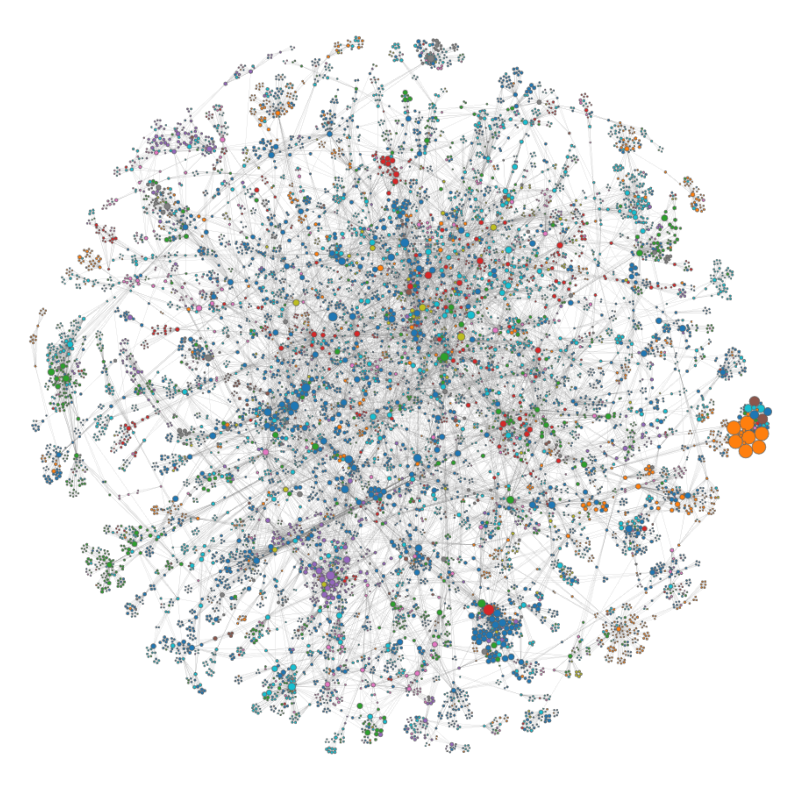

In [19]:
print("largest connected component color coded by country, sized by citation count")
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('network.png'))
plt.axis('off')
plt.show()

Immediately, it is apparant that people from the same countries tend to cooperate together, which makes sense since people studying in the same institutions are likely to collaborate

**Preliminary Network Analysis**

In [20]:
print("1. Network metrics")
print(f"Total number of nodes: {len(graph.nodes)}, total number of links: {len(graph.edges)}")
density = nx.density(graph)
print(f"Network density: {np.round(density,7)}, The network is sparse, since only {np.round((density)*100, 2)}% of all possible links are present.")
print(f"The network is connected: {nx.is_connected(graph)}")
print(f"The network has {nx.number_connected_components(graph)} connected components.")
print(f"The size of the largest connected component: {len(max(nx.connected_components(graph), key=len))}")
print(f"The networks has {len(list(nx.isolates(graph)))} isolated nodes.")


1. Network metrics
Total number of nodes: 12480, total number of links: 38747
Network density: 0.0004976, The network is sparse, since only 0.05% of all possible links are present.
The network is connected: False
The network has 235 connected components.
The size of the largest connected component: 9667
The networks has 1 isolated nodes.


The network metrics tell us about the collaborative tendencies of researchers. We can see that there are 235 different groups of researchers who has never collaborated directly or indirectly with others. We can also see that the largest component contains about 77% of all the found researchers, which suggests a substantual level of collaboration within the network, as well as underlining the collaborative nature of research.\

The presence of 235 group suggests rich opportunity for further collaborative work that potentially can lead to newer research and knowledge sharing between researchers

In [21]:
print("2. Degree analysis")
avg_degree = np.mean(list(dict(graph.degree()).values()))
avg_degree = np.round(avg_degree, 2)
median_degree = np.median(list(dict(graph.degree()).values()))
minimum_degree = min(dict(graph.degree()).values())
maximum_degree = max(dict(graph.degree()).values())
print(f"Average degree: {avg_degree}, median degree: {median_degree}, minimum degree: {minimum_degree}, maximum degree: {maximum_degree}")

print("")
print("Weighted degree analysis")
avg_weighted_degree = np.mean(list(dict(graph.degree(weight='weight')).values()))
avg_weighted_degree = np.round(avg_weighted_degree, 2)
median_weighted_degree = np.median(list(dict(graph.degree(weight='weight')).values()))
minimum_weighted_degree = min(dict(graph.degree(weight='weight')).values())
maximum_weighted_degree = max(dict(graph.degree(weight='weight')).values())
print(f"Average weighted degree: {avg_weighted_degree}, median weighted degree: {median_weighted_degree}, minimum weighted degree: {minimum_weighted_degree}, maximum weighted degree: {maximum_weighted_degree}")

#print the author with the highest degree
highest_degree_author = max(dict(graph.degree()).items(), key=lambda x: x[1])
print(f"The author with the highest degree is {highest_degree_author[0]} with a degree of {highest_degree_author[1]}")

2. Degree analysis
Average degree: 6.21, median degree: 5.0, minimum degree: 0, maximum degree: 184

Weighted degree analysis
Average weighted degree: 8.36, median weighted degree: 5.0, minimum weighted degree: 0, maximum weighted degree: 370
The author with the highest degree is https://openalex.org/A5088141761 with a degree of 184


The average degree tells us that every researcher has worked with 6 other people on average. We also see that the most collaborated with author has worked with 184 different people. People with a high degree are key in information flow between various researchers, since they work with so many people

In [22]:
print("3. Top authors")
top_authors = sorted(dict(graph.degree()).items(), key=lambda x: x[1], reverse=True)[:10]
for author, degree in top_authors[:5]:
    print(f"{author}: {degree}")

3. Top authors
https://openalex.org/A5088141761: 184
https://openalex.org/A5044944954: 148
https://openalex.org/A5075080019: 148
https://openalex.org/A5029100305: 138
https://openalex.org/A5017914184: 133


What area do the authors specialize in? (max 150 words)
The authors are
 - Jonathan D. Cohen\
Jonathan studies neuroscience. His most cited work is "An integrative Theory of Prefrontal Cortex function", and he is a professor at Psychology at Princeton University, where he also is the founding co-director at the Princeton Neuroscience Institute.
 - Lyle H. Ungar\
Lyle is a computer scientist. His most cited work is "Methods and Metrics for cold-start recommendations". He is also a machine learning researcher and professor at the University of Pennsylvania
 - Qin Li\
Qin seems to study biology as her most cited paper is "Cellular and humoral immune responses to viral antigens create barriers to lung-directed gene therapy with recombinant adenoviruses", she is affiliated with the Chinese Academy of Sciences and Peking University.
 - Denny Borsboom\
Dennis is a psychologist. His most cited work is "Estimating the reproducibility of psychological science". He is also a professor of psychology at the University of Amsterdam.
 - Stephan Lewandowsky\
Stephan is an australian psychologist. His most cited work is "Misinformation and Its Correction". He is currently at the University of Bristol, where he is the chair of cognitive psychology